In [1]:
import pandas as pd
import warnings
from pandas.core.common import SettingWithCopyWarning
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

#### PICKING SPIDERS OF INTEREST: 

Below, we'll use several processes to decide which species we'll be conducting PCA on.


##### 1. Species with FRPs close to each other

In [2]:
def dec1(dfDD, dfLD):
    
    """
    dfDD: dataframe containing DD data
    dfLD: dataframe containing LD data
    """
    
    dfDD = pd.read_csv(str(dfDD))
    dfLD = pd.read_csv(str(dfLD))
    
    # join LD data with FRP data from DD dataframe
    dfLD = dfLD.drop(columns = ["LombSc period"])
    dfDDfrp = dfDD[["LombSc period"]]
    concat = pd.concat([dfLD, dfDDfrp], axis=1)
    
    #find average FRP for each specie 
    df = concat[["Specie Name", "LombSc period"]]
    global grp
    grp = df.groupby("Specie Name").mean()
    display(grp)

In [3]:
dec1("all_spider_summary_DD.csv", "all_spider_summary_LD.csv")

,LombSc period
Specie Name,
Acanthapeira stellata,24.210593
Allocyclosa bifurca,18.155538
Anelosimus studiosus,22.843599
Argiope aurantia,20.313599
Centruroides vittatus,24.821237
Cyclosa turbinata,18.249326
Frontinella pyramitela,27.328255
Gasteracantha cancriformis,20.373121
Larinioides cornutus,24.122514


###### Species with FRPs closest to 24 hours: M. fauroti, P. phalangioides, L. cornutus, P. manueli 


Dataframe preparation

In [4]:
four = pd.read_csv("four.csv")
four = four.drop(columns = ["Unnamed: 0"])
def family(row):  
    """
    add more if/return statements to conduct PCA on more species
    """
    
    if row["Specie Name"] == 'Micropholcus fauroti':
        return "Pholcidae"
    if row["Specie Name"] == "Pholcus phalangioides":
        return "Pholcidae"
    if row["Specie Name"] == 'Larinioides cornutus':
        return "Araneidae Orb-Weaver"
    if row["Specie Name"] == "Pholcus manueli":
        return "Pholcidae"
    
four['Family'] = four.apply (lambda row: family(row), axis=1)
def converttohours():
    global four
    xpd = [pd.to_datetime(i).time() for i in four["Mean activity onset"].values]
    ot = [i.hour + i.minute * (1/60) for i in xpd]
    four["Ot Mean Onset"] = ot
converttohours()
four = four.drop(columns = ["Mean activity onset"])
four

,Specie Name,Spider ID,DiNoc ratio,LombSc period,Family,Ot Mean Onset
0,Larinioides cornutus,Monitor 3 Spider 1,-1.674304,25.878055,Araneidae Orb-Weaver,19.533333
1,Larinioides cornutus,Monitor 3 Spider 2,-1.510802,23.339690,Araneidae Orb-Weaver,19.450000
2,Larinioides cornutus,Monitor 3 Spider 3,-1.928278,24.709813,Araneidae Orb-Weaver,19.633333
3,Larinioides cornutus,Monitor 3 Spider 4,-0.975257,24.457992,Araneidae Orb-Weaver,20.550000
4,Larinioides cornutus,Monitor 3 Spider 5,-1.099625,23.989514,Araneidae Orb-Weaver,19.250000
...,...,...,...,...,...,...
123,Pholcus phalangioides,Monitor 15 Spider 12,-1.960272,24.265822,Pholcidae,19.250000
124,Pholcus phalangioides,Monitor 15 Spider 13,-1.952876,23.810231,Pholcidae,19.150000
125,Pholcus phalangioides,Monitor 15 Spider 14,-2.000538,26.239921,Pholcidae,19.566667
126,Pholcus phalangioides,Monitor 15 Spider 17,-1.759010,24.261545,Pholcidae,20.350000


###### PCA Calc

In [5]:
dfpho = four[four.Family == "Pholcidae"]  #pholcidae df
dfara = four[four.Family == "Araneidae Orb-Weaver"]  #orb-weaver df
four2 = dfpho.append(dfara, ignore_index = True)

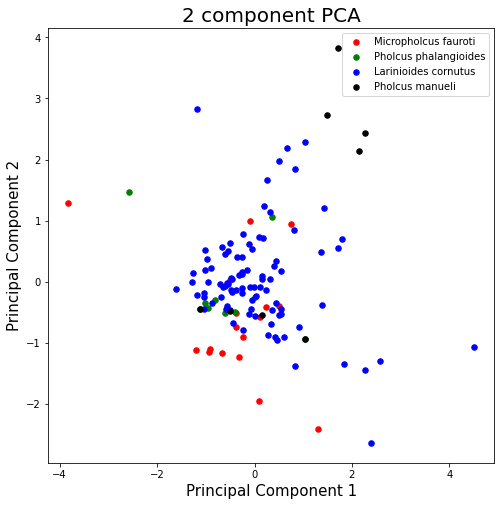

In [27]:
features = ["LombSc period","DiNoc ratio", "Ot Mean Onset"]
x = four2.loc[:, features].values
y = four2.loc[:,['Specie Name']]
x = StandardScaler().fit_transform(x)


pca = PCA(n_components=2)

principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
              , columns = ['principal component 1', 'principal component 2'])

finalDf = pd.concat([principalDf, four2], axis = 1)
finalDf

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['Micropholcus fauroti', "Pholcus phalangioides", "Larinioides cornutus", "Pholcus manueli"]
colors = ['r', 'g', 'b', 'k']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['Specie Name'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 30)
ax.legend(targets)

#### Clustering of the L. cornutus ! Seems promising.

Next, let's just look at M. fauroti, P. phalangioides, and P. manueli since they are from the same family

In [7]:
four[four["Specie Name"] == "Larinioides cornutus"]
four = four.drop(labels=range(0, 93), axis=0)

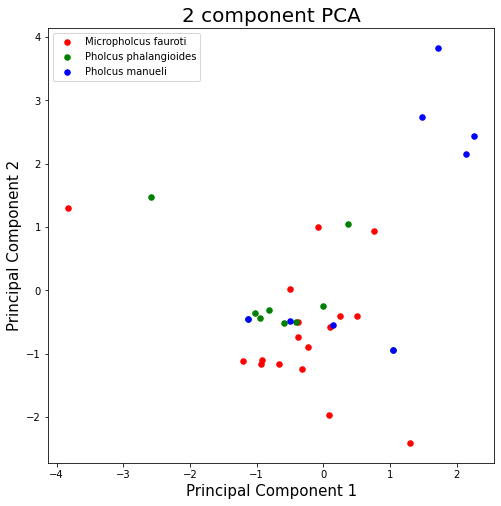

In [26]:
features = ["LombSc period","DiNoc ratio", "Ot Mean Onset"]
x = four2.loc[:, features].values
y = four2.loc[:,['Specie Name']]
x = StandardScaler().fit_transform(x)


pca = PCA(n_components=2)

principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
              , columns = ['principal component 1', 'principal component 2'])

finalDf = pd.concat([principalDf, four2], axis = 1)
finalDf

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['Micropholcus fauroti', "Pholcus phalangioides", "Pholcus manueli"]
colors = ['r', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['Specie Name'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 30)
ax.legend(targets)

#### L. cornutus seems to be our most promising guide so far, so let's compare it with M. wittfeldae, which proved helpful in earlier analyses. 

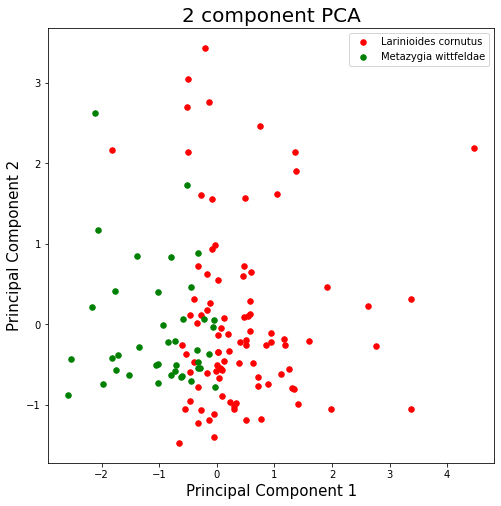

In [25]:
two = pd.read_csv("two.csv")
two = two.drop(columns = ["Unnamed: 0"])
features = ["LombSc period","DiNoc ratio", "Ot Mean Onset"]
x = two.loc[:, features].values
y = two.loc[:,['Specie Name']]
x = StandardScaler().fit_transform(x)


pca = PCA(n_components=2)

principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
              , columns = ['principal component 1', 'principal component 2'])

finalDf = pd.concat([principalDf, two], axis = 1)
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['Larinioides cornutus', 'Metazygia wittfeldae']
colors = ['r', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['Specie Name'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 30)
ax.legend(targets)

#### Conclusion: Clusters! Next step will be to conduct regression analyses to investigate which of the measures are causing the patterns we're seeing. 